In [12]:
#..........................案例1:
#.......................... 了解TensorFlow
#..........运行高效，可以在多个CPU或GPU上并行计算，并支持分布式计算
# tensorflow-gpu用于支持GPU
# conda install h5py
# conda install tensorboard
# pip install ...tensorflow.whl
# 创建一个图谱(不执行任何计算)
# （这称为构造阶段）
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # 网上好多教程是1.0，2.0不兼容1.0，这一句很重要
x = tf.Variable(3, name="x")
# w=tf.constant(3)
y = tf.Variable(4, name="y")
f = x*x*y + y + 2
# 创建一个会话
# （这是执行阶段）
with tf.compat.v1.Session() as sess: # with运行完后自动关闭
    x.initializer.run() # 初始化
    y.initializer.run() # 初始化
    result = f.eval() # 运行,sess.run(f)也行
print(result)

# 创建的节点都会添加到默认图形中
print('2:',x.graph is tf.compat.v1.get_default_graph())
# 创建独立于默认的新图
graph=tf.compat.v1.Graph()
with graph.as_default():
    x2=tf.Variable(2)
print('3:',x2.graph is graph,x2.graph is tf.compat.v1.get_default_graph())
# jupyter中多次运行，可能会出现重复节点，因此tf.reset_default_graph() 来重置默认图
# 节点生命周期
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
# with tf.compat.v1.Session() as sess:
# print(y.eval())
# print(z.eval())
# 每次运行都是单独的图形，w和x会重复计算，如果需要避免多次计算：
with tf.compat.v1.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val) # 10
    print(z_val) # 15
# 单进程中，多个会话不共享任何状态；分布式中，变量状态存在服务器，不在会话中，可以共享。

42
2: True
3: True False
10
15


In [13]:
#..........................案例2:
#..........................基于TensorFlow的线性回归
import numpy as np
import pandas as pd
# 数据
from sklearn.preprocessing import StandardScaler
file=r'C:\Users\Wudey\OneDrive - whu.edu.cn\数据分析学习\【数据】Hands-On Machine Learning with Scikit-Learn & TensorFlow\housing.csv'
housing=pd.read_table(file,delimiter=',')
housing_t=housing["median_house_value"] # 因变量
h_a=housing.drop(['median_house_value','ocean_proximity'],axis=1)
housing_a=np.array(h_a.fillna(0)) # 填补缺失值
scal=StandardScaler()
housing_a=scal.fit_transform(housing_a)
m,n=housing_a.shape
housing_data_plus_bias=np.c_[np.ones((m, 1)), housing_a] # 添加截距项
# tensorFlow过程
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X") # 自变量
# 注意：shape(2,1)跟shape(2,)是不一样的，要用reshape来处理
y = tf.constant(np.array(housing_t).reshape(20640,1), dtype=tf.float32, name="y")
XT = tf.transpose(X) # 转置
theta = tf.matmul(tf.matmul(tf.compat.v1.matrix_inverse(tf.matmul(XT, X)), XT),y)  # matmul矩阵相乘
with tf.compat.v1.Session() as sess:
    theta_value = theta.eval()
print(theta_value)

[[206855.67 ]
 [-85035.92 ]
 [-90600.08 ]
 [ 14342.191]
 [-11436.013]
 [ 24172.428]
 [-46222.355]
 [ 38310.51 ]
 [ 74750.336]]


In [14]:
#..........................基于TensorFlow的梯度下降
n_epochs = 1000
learning_rate = 0.01
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(np.array(housing_t).reshape(20640,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0), name="theta") # 初始权重（系数）
y_pred = tf.matmul(X, theta, name="predictions") # 首次预测值
error = y_pred - y # 首次误差项
mse = tf.reduce_mean(tf.square(error), name="mse") # 均方误差
# gradients = 2/m * tf.matmul(tf.transpose(X), error) # 梯度下降公式
# （gradients = tf.gradients(mse, [theta])[0] # 自带的梯度下降公式）
# training_op = tf.compat.v1.assign(theta, theta - learning_rate * gradients) # 调整权重
# 优化的梯度下降
optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
# 动量优化器：tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op=optimizer.minimize(mse)
init = tf.compat.v1.global_variables_initializer()
with tf.compat.v1.Session() as sess:
    for epoch in range(n_epochs):
        sess.run(init) # 全部初始化,注意每迭代一次都需要初始化，不然就变量NA
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op) # 让每次计算都迭代
    best_theta = theta.eval()

Epoch 0 MSE = 56105070000.0
Epoch 100 MSE = 56104880000.0
Epoch 200 MSE = 56105054000.0
Epoch 300 MSE = 56105280000.0
Epoch 400 MSE = 56105100000.0
Epoch 500 MSE = 56104727000.0
Epoch 600 MSE = 56104546000.0
Epoch 700 MSE = 56104563000.0
Epoch 800 MSE = 56104493000.0
Epoch 900 MSE = 56104990000.0


In [43]:
# 小批量梯度下降
# 占位符placeholder，不计算，只输出运行时的数据
A = tf.compat.v1.placeholder(tf.float32, shape=(None, 3))
B=A+5
with tf.compat.v1.Session() as sess:
    B_val_1=B.eval(feed_dict={A:[[1,2,3]]}) # 必须具有三列，与前面一致
    B_val_2=B.eval(feed_dict={A:[[4,5,6],[7,8,9]]})
print(B_val_2)
# 小批量梯度完整版
learning_rate = 0.01
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
init = tf.compat.v1.global_variables_initializer()
n_epochs = 100
batch_size = 100
n_batches = int(np.ceil(m / batch_size)) # ceil() 方法返回 x 的值上限 - 不小于 x 的最小整数。
saver = tf.compat.v1.train.Saver()
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index) # 可重复
    indices = np.random.randint(m, size=batch_size) # not shown
    X_batch = housing_data_plus_bias[indices] # not shown
    y_batch = np.array(housing_t).reshape(20640,1)[indices] # not shown
    return X_batch, y_batch
with tf.compat.v1.Session() as sess:
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            sess.run(init)
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()
    save_path=saver.save(sess,"/tmp/my_final.ckpt")
print(best_theta)
# 恢复模型：
# with tf.compat.v1.Session() as sess:
#     saver.restore(sess, "/tmp/my_model_final.ckpt")

[[ 9. 10. 11.]
 [12. 13. 14.]]
[[4078.806   ]
 [ -60.824013]
 [-366.01053 ]
 [ -95.40403 ]
 [-278.247   ]
 [-438.13663 ]
 [-373.22113 ]
 [-370.9333  ]
 [2101.3271  ]]


In [46]:
# 回到批量梯度下降（以下代码出了问题，有空研究一下）
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = r"C:\Users\Wudey\Desktop\tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())
n_epochs = 100
learning_rate = 0.01
class summ():
    def __init__(self,value):
        self.value=value
with tf.compat.v1.Session() as sess:
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            sess.run(init)
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()
print(best_theta)
file_writer.close()
# cmd: tensorboard --logdir tf_logs/ 就可以看到图形

AttributeError: 'numpy.bool_' object has no attribute 'value'

In [29]:
## 项目1：基本图像分类
import tensorflow as tf
from tensorflow import keras # tf的高级api
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels)=fashion_mnist.load_data() # 四个 NumPy 数组
# train_images的维度是（60000,28,28）
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # y值的标签

2.2.0
4423680/4422102 [==============================] - 6s 1us/step


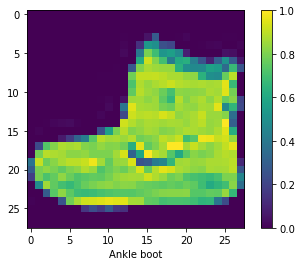

In [32]:
# 数据预处理
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[train_labels[0]])
plt.show()
# 归一化
train_images = train_images / 255.0
test_images = test_images / 255.0

In [33]:
# 建模
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), # 格式化数据，转一维数组
    keras.layers.Dense(128, activation='relu'), # 第一层，128个神经元
    keras.layers.Dense(10) # 最后一层，返回长度10的logits数组，每个都包含一个得分
])
# 模型编译时的选项
model.compile(optimizer='adam', # 优化器
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 损失函数
              metrics=['accuracy']) # 监控指标
model.fit(train_images, train_labels, epochs=10) # 训练模型（0.844）


Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0719 - accuracy: 0.6703
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6343 - accuracy: 0.7720
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5599 - accuracy: 0.8008
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5178 - accuracy: 0.8174
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4904 - accuracy: 0.8269
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4704 - accuracy: 0.8350
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4557 - accuracy: 0.8392
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4441 - accuracy: 0.8441
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4343 - accuracy: 0.8470
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.426

In [35]:
# 训练和预测
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc) # 略微过拟合
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()]) # 再附加一层，输出概率，方便预测，也可以一开始加上或者使用model.add()
predictions = probability_model.predict(test_images)
print(predictions[0])
print(np.argmax(predictions[0]))

313/313 - 1s - loss: 0.4556 - accuracy: 0.8365

Test accuracy: 0.8364999890327454
[9.4867102e-07 1.6498666e-08 3.1918748e-06 3.5523854e-06 7.0111605e-06
 2.0919439e-01 2.3712593e-05 2.5968418e-01 4.4122394e-03 5.2667075e-01]
9
